# Calculando Largura de Vias

Neste Jupyter Notebook vamos validar a POC calculando a largura de vias para todo um distrito que possui Polígono de vias desenhado

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (40, 30)

In [2]:
# df_qf = gpd.read_file(f'gis/SIRGAS_SHP_quadraMDSF.shp')
# df_qv = gpd.read_file(f'gis/SIRGAS_SHP_quadraviariaed_polygon.shp')
df_l = gpd.read_file(f'gis/SIRGAS_SHP_logradouronbl.shp')

In [3]:
df_s = gpd.read_file(f'gis/SIRGAS_SHP_distrito_polygon.shp')
df_s = df_s[df_s['ds_nome'] == 'VILA MARIANA']

In [4]:
# df_pvias = gpd.read_file("./resultado/poligono_de_vias.gpkg", layer='90 - poligono de vias de vila mariana')
df_pvias = gpd.read_file('resultado/poligono_de_vias_vila_mariana.gpkg')

## Limitando as vias que intersectam os poligonos

In [5]:
df_s_sindex = df_s.sindex
df_l_sindex = df_l.sindex

In [6]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(df_s.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
l_candidate_idx = list(df_l_sindex.intersection(bounds))
l_candidates = df_l.loc[l_candidate_idx]

In [7]:
df_l = gpd.clip(l_candidates, df_s)

## Criando pontos regulares sobre as linhas da via

In [8]:
import math
from shapely.geometry import MultiPoint

dist = 12.00

points = df_l.apply(lambda x: MultiPoint([x.geometry.interpolate(((i)*dist)+dist/2+(x.geometry.length%dist)/2) 
                                              for i in range(math.floor(x.geometry.length/dist))]), 
                        axis=1)

df_points = gpd.GeoDataFrame(geometry=points)

## Relacionando o ponto ao seu polígono de via

In [9]:
gpd.sjoin(df_points, df_pvias, how='left', op='intersects')

<ipython-input-9-f3858c6b4a61>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:31983

  gpd.sjoin(df_points, df_pvias, how='left', op='intersects')


,geometry,index_right
42020,GEOMETRYCOLLECTION EMPTY,NaN
171488,GEOMETRYCOLLECTION EMPTY,NaN
141164,GEOMETRYCOLLECTION EMPTY,NaN
21724,GEOMETRYCOLLECTION EMPTY,NaN
58551,GEOMETRYCOLLECTION EMPTY,NaN
...,...,...
198119,GEOMETRYCOLLECTION EMPTY,NaN
198113,"MULTIPOINT (331584.100 7389327.988, 331583.899...",1758.0
158482,MULTIPOINT (331575.382 7389335.902),2040.0
158486,MULTIPOINT (331575.384 7389335.944),2040.0


In [10]:
points = df_points.apply(lambda x: list(x.geometry.geoms), axis=1)
df_p = gpd.GeoDataFrame(geometry=[item for sublist in points for item in sublist])

In [11]:
df_points = gpd.sjoin(df_p, df_pvias, how='left', op='intersects', rsuffix='pvias')

<ipython-input-11-bdc8ba3059c9>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:31983

  df_points = gpd.sjoin(df_p, df_pvias, how='left', op='intersects', rsuffix='pvias')


## Quadras e canteiros

Para que possamos calcular a distância de cada um desses pontos gerados precisamos saber as mínimas distâncias para cada elemento que não seja via. Podemos chamar genericamente de quadras, porém existem canteiros tb.

In [12]:
df_nao_vias = gpd.overlay(gpd.GeoDataFrame(geometry=df_s.buffer(10)), df_pvias, how='difference')

<ipython-input-12-a0812791d6c1>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:31983

  df_nao_vias = gpd.overlay(gpd.GeoDataFrame(geometry=df_s.buffer(10)), df_pvias, how='difference')


In [13]:
# df_nao_vias.geometry.map(lambda x: list(x))
quadras = [item for sublist in df_nao_vias.geometry.map(lambda x: list(x)) for item in sublist]
df_quadras = gpd.GeoDataFrame(geometry=quadras)

In [14]:
# df_quadras_splited = gpd.overlay(gpd.GeoDataFrame(geometry=df_l.buffer(40, cap_style=2)), df_quadras, how='intersection')
# df_quadras_splited

In [15]:
# df_quadras_splited.plot()

## Relacionando as quadras adjacentes ao polígono de vias

In [16]:
df_pvia_quadra = gpd.sjoin(df_pvias, df_quadras, how='left', op='intersects', rsuffix='quadra')
df_pvia_quadra.index.name = 'id'
df_pvia_quadra

<ipython-input-16-451df893646b>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:31983
Right CRS: None

  df_pvia_quadra = gpd.sjoin(df_pvias, df_quadras, how='left', op='intersects', rsuffix='quadra')


,geometry,index_quadra
id,,
0,"POLYGON ((334111.804 7391527.195, 334123.792 7...",113.0
0,"POLYGON ((334111.804 7391527.195, 334123.792 7...",0.0
1,"POLYGON ((334188.583 7391528.284, 334217.988 7...",102.0
1,"POLYGON ((334188.583 7391528.284, 334217.988 7...",0.0
2,"POLYGON ((334278.882 7391529.768, 334291.766 7...",73.0
...,...,...
2227,"POLYGON ((332583.218 7391954.238, 332583.453 7...",NaN
2228,"POLYGON ((332548.029 7392030.347, 332545.471 7...",0.0
2229,"POLYGON ((332493.863 7392065.078, 332489.820 7...",0.0


## Calculando as distâncias

In [17]:
from shapely.ops import nearest_points
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split

In [18]:
def calc_distancia(p):
    quadras = list(df_pvia_quadra[df_pvia_quadra.index == p.index_pvias].index_quadra)
    quadras = df_quadras[df_quadras.index.isin(quadras)]
    pontos  = []
    
    for i, row in quadras.iterrows():
        pontos.append(nearest_points(p.geometry, row.geometry)[1])
    
    if len(pontos) == 2:   
        return LineString(pontos)
    elif len(pontos) > 2:  
        bd = split(MultiPoint(pontos).convex_hull.boundary, MultiPoint(pontos))
        return min(bd, key=(lambda x: x.length))
    else:
        return None
    

# df_dists = gpd.GeoDataFrame(geometry=df_points.apply(lambda x: calc_distancia(x), axis=1))
ps = df_points.apply(lambda x: calc_distancia(x), axis=1)

In [19]:
ps

0        LINESTRING (332002.3566121007 7391878.16069664...
1        LINESTRING (332013.3388267529 7391882.99686202...
2        LINESTRING (332024.3407605927 7391887.84184669...
3        LINESTRING (332035.2990454368 7391892.73223531...
4        LINESTRING (332046.257330281 7391897.622623942...
                               ...                        
14344    LINESTRING (331582.1145554539 7389389.89427948...
14345    LINESTRING (331581.2327427288 7389377.92680595...
14346    LINESTRING (331580.3500493824 7389366.02028876...
14347    LINESTRING (331579.2678789211 7389354.06934398...
14348    LINESTRING (331576.08889 7389347.38877, 331587...
Length: 14349, dtype: object

In [20]:
# ps.map(lambda x: len(x)).unique()

In [21]:
df_ps = gpd.GeoDataFrame(geometry=ps)

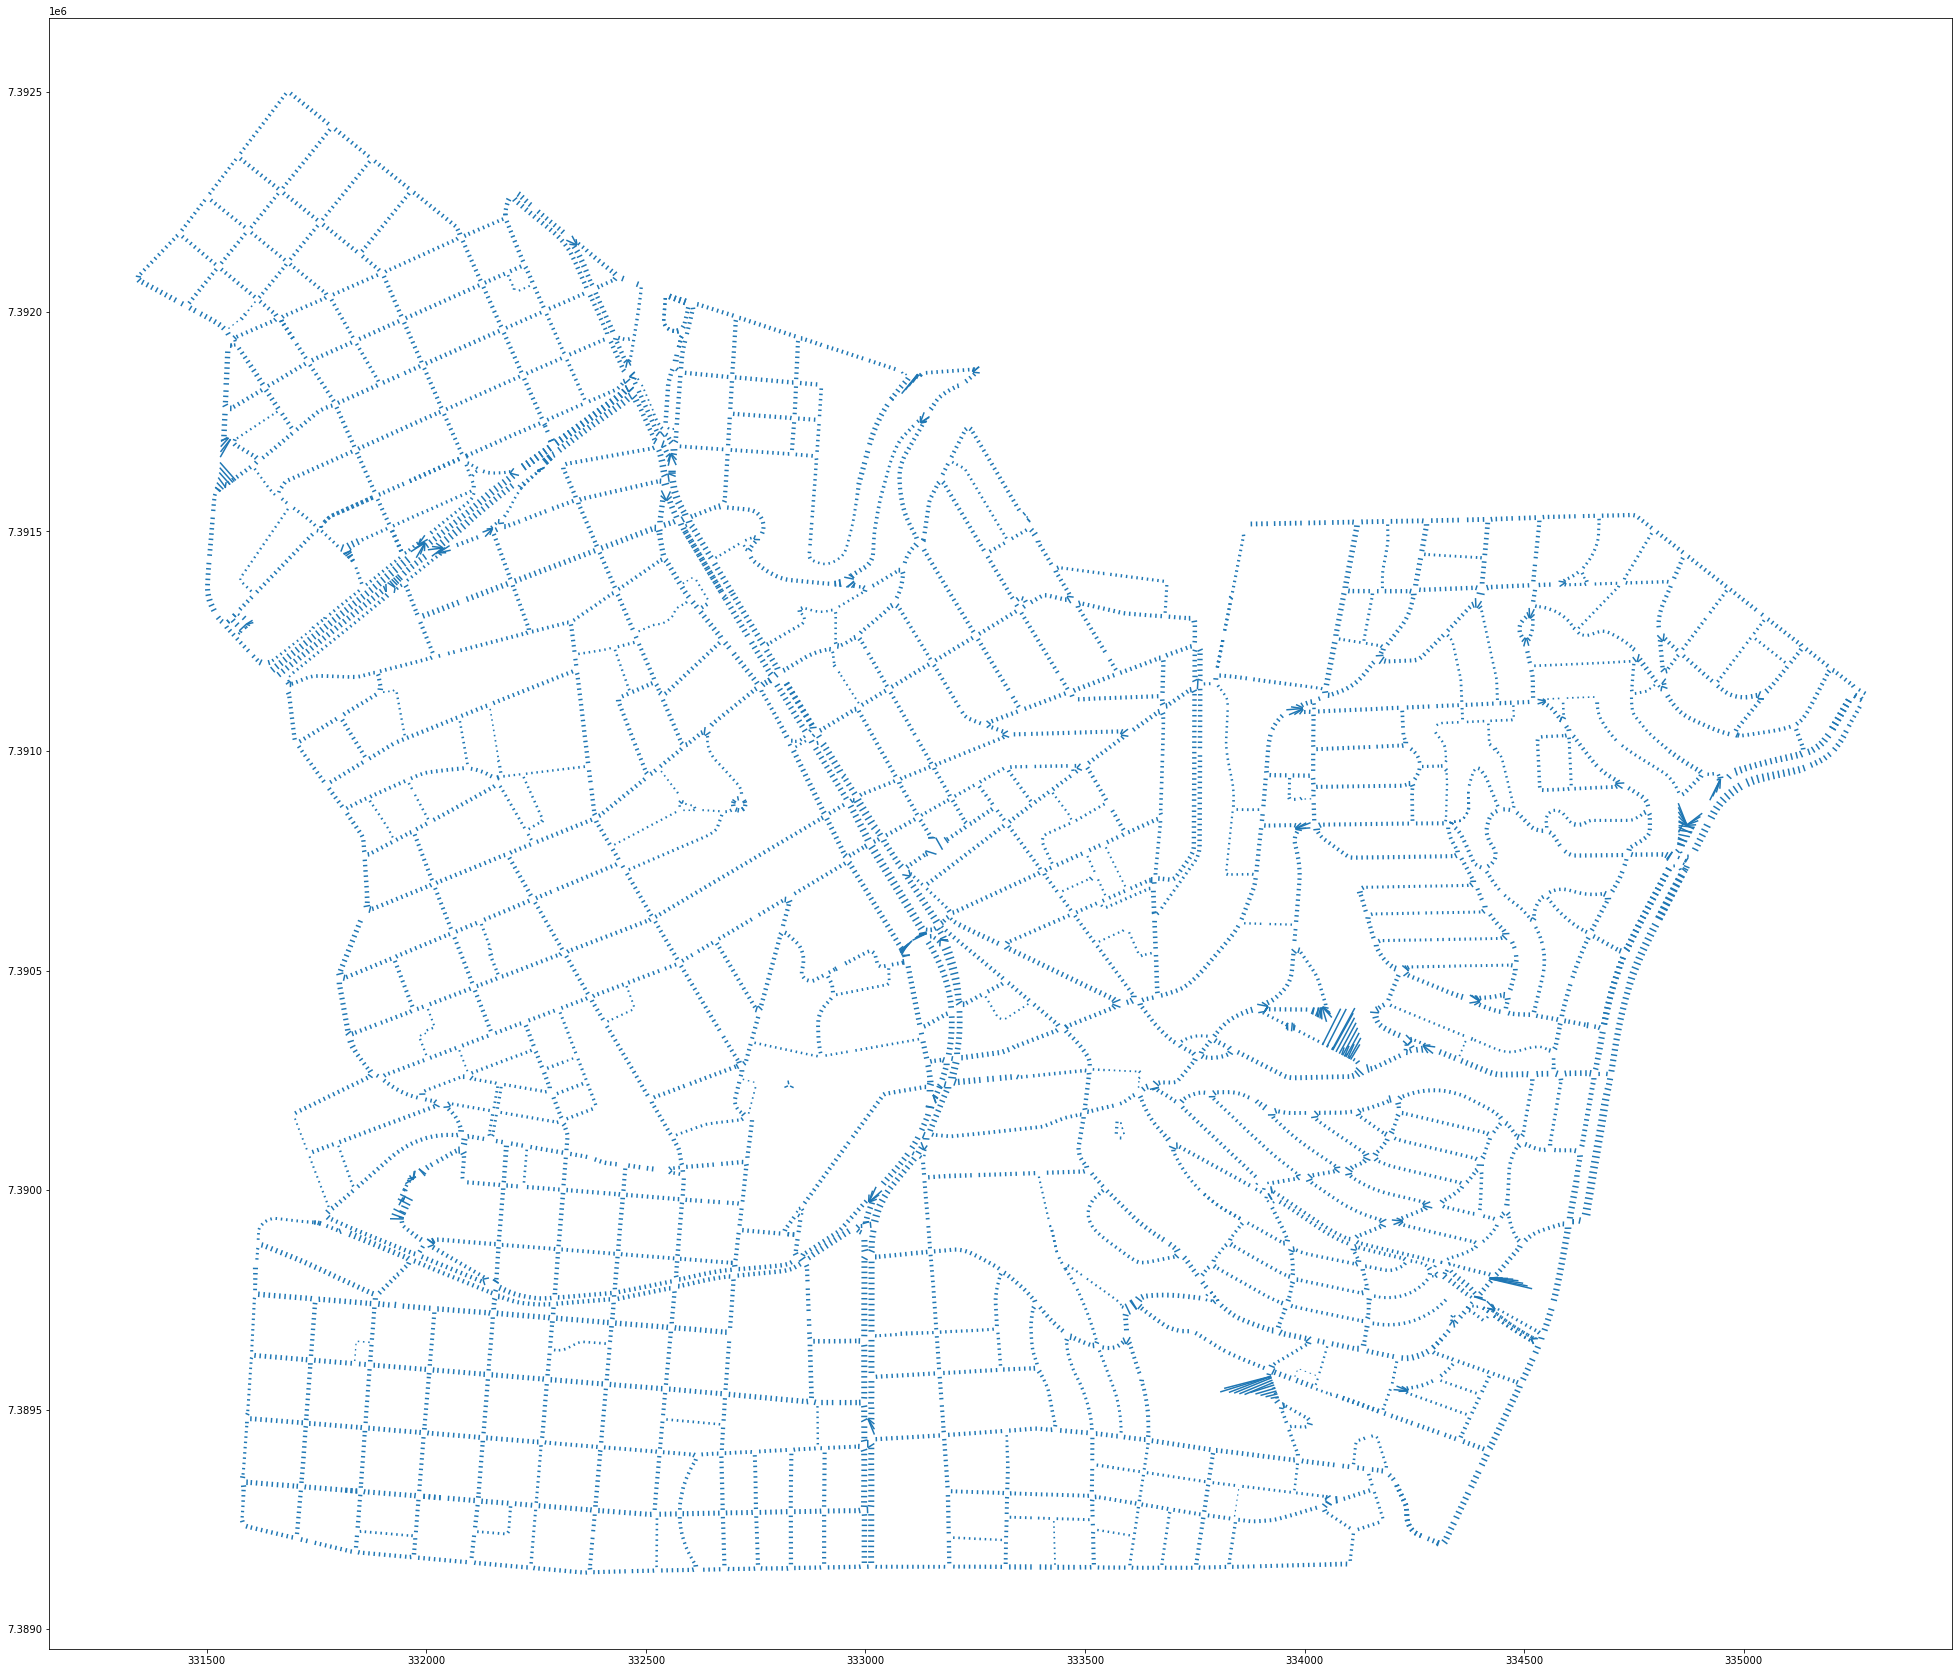

In [22]:
df_ps.plot()

In [23]:
df_ps.to_file("./resultado/largura_de_vias_90_vila_mariana.gpkg", driver="GPKG")

In [47]:
df_ps[df_ps.is_valid].geometry.apply(lambda x: x.interpolate(0.5, normalized=True))

0        POINT (332000.274 7391882.847)
1        POINT (332011.243 7391887.714)
2        POINT (332022.221 7391892.586)
3        POINT (332033.208 7391897.472)
4        POINT (332044.184 7391902.322)
                      ...              
14344    POINT (331585.720 7389389.619)
14345    POINT (331584.805 7389377.654)
14346    POINT (331583.824 7389365.698)
14347    POINT (331582.715 7389353.749)
14348    POINT (331581.758 7389346.356)
Name: geometry, Length: 12064, dtype: geometry